# **COVID-19 CASUALTIES AND COMORBIDITIES** #
# *A Machine Learning approach to define and evaluate a prediction model in the pandemic spread analysis*

***A Jupyter Notebook by Cristiano Esposito ©2021***
<br>***Release 1.0 - last update Apr. 21, 2021***

Import all the neeed libraries that will be later used to perform the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Now we'll import the main dataset (<a href='https://github.com/beoutbreakprepared/nCoV2019/tree/master/latest_data'>here</a> is the link to the nCoV2019 dataset.)

In [2]:
data = pd.read_csv('./data/latestdata.csv', sep=',', low_memory=False)

Let's give a look to our data:

In [3]:
data.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,...,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,...,NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,...,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,...,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,...,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,...,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN


As we can see, there are a lot of missing values in our dataset, hence we first need some wrangling and cleaning before it's possible to manipulate the values.<br>

In [4]:
data.columns

Index(['ID', 'age', 'sex', 'city', 'province', 'country', 'latitude',
       'longitude', 'geo_resolution', 'date_onset_symptoms',
       'date_admission_hospital', 'date_confirmation', 'symptoms',
       'lives_in_Wuhan', 'travel_history_dates', 'travel_history_location',
       'reported_market_exposure', 'additional_information',
       'chronic_disease_binary', 'chronic_disease', 'source',
       'sequence_available', 'outcome', 'date_death_or_discharge',
       'notes_for_discussion', 'location', 'admin3', 'admin2', 'admin1',
       'country_new', 'admin_id', 'data_moderator_initials',
       'travel_history_binary'],
      dtype='object')

Ispectioning the dataframe, I've found out that some features are not necessary at this point so I can get rid of unwanted informations (better and further wrangling will be evaluated and applied in a later state). I'm going to keep only demographic and medical features, as well as the outcome of the hospitalization.

In [5]:
data = data[['age', 'sex', 'country', 'latitude', 'longitude', 'symptoms', 'additional_information','chronic_disease_binary', 'chronic_disease', 'outcome']]

<p>Let's see how big is our current dataframe

In [6]:
data.shape

(2676311, 10)

<p>It looks like a huge amount of samples but we are going to reduce them by removing all empty informations

In [7]:
data.dropna(subset=['chronic_disease'], inplace=True)
data.dropna(subset=['outcome'], inplace=True)

In [8]:
#checking the new dataframe size
data.shape

(125, 10)

<p>So the cleaning stage provided a smaller dataset, further methods to keep as many samples as possible are currently understudy and we'll be applied in a further stage.<p>Since the model will be fit using pre-existing medical conditions at the time of hospitalization, I need to perform some filter on the 'chronic_disease' column to define new features:

In [9]:
data.chronic_disease.unique()

array(['Iran; Kuala Lumpur, Federal Territory of Kuala Lumpur, Malaysia',
       'hypertension', 'COPD', 'diabetes, hypertension',
       '"thought to have had other pre-existing conditions"',
       'HIV positive',
       'history of hypertension, type 2 diabetes, coronary heart disease for which a stent had been implanted, and lung cancer',
       'prostate hypertrophy', 'hepatitis B, diabetes',
       'hypertension, diabetes', 'chronic bronchitis', 'diabetes',
       'coronary heart disease', 'diabetes, coronary heart disease',
       'hypertension, coronary heart disease, diabetes, Tuberculosis',
       'hypertension, chronic obstructive pulmonary disease, diabetes, chronic renal insufficiency',
       'diabetes, cerebral infarction',
       'hypertension, diabetes, coronary heart disease, frequent ventricular premature beat (FVPB), coronary artery stenting',
       'hypertension, cerebral infarction, encephalomalacia',
       'hypertension, hip replacement',
       "Parkinson's di

Looking at the values provided in the dataset, a custom filter algorithm has been deployed to better categorize each disease and define new columns where a disease is defined as present (int value of 1) or absent (int value of 0) for every sample in the dataframe

In [10]:
#diabetes
diabetes = ['diabetes', 'impaired fasting glucose']
data['diabetes'] = data.chronic_disease.str.contains('|'.join(diabetes)).astype(int)
#hypothyroidism
data['hypothyroidism'] = data.chronic_disease.str.contains("hypothyroidism").astype(int)
#hyperthyroidism
data['hyperthyroidism'] = data.chronic_disease.str.contains("hyperthyroidism").astype(int)
#cancer
data['cancer'] = data.chronic_disease.str.contains("cancer").astype(int)
#Parkinson
data['Parkinson'] = data.chronic_disease.str.contains("Parkinson").astype(int)
#asthma
data['asthma'] = data.chronic_disease.str.contains("asthma").astype(int)
#HIV
data['HIV_positive'] = data.chronic_disease.str.contains("HIV").astype(int)
#hepatits
data['hepatitis'] = data.chronic_disease.str.contains("hepatitis").astype(int)
#hypertension
data['hypertension'] = data.chronic_disease.str.contains("hypertension").astype(int)
#dyslipidemia
data['dyslipidemia'] = data.chronic_disease.str.contains("dyslipidemia").astype(int)
#Tuberculosis
data['Tuberculosis'] = data.chronic_disease.str.contains("Tuberculosis").astype(int)
#bronchitis
data['bronchitis'] = data.chronic_disease.str.contains("bronchitis").astype(int)
#prostatic hypertrophy
prostatic = ['prostatic hypertrophy', 'prostatic hyperplasia']
data['prostiatic_hypertrophy']=data['chronic_disease'].str.contains('|'.join(prostatic)).astype(int)
#COPD
COPD = ['COPD', 'chronic obstructive pulmonary disease', 'pulmonary']
data['COPD']=data['chronic_disease'].str.contains('|'.join(COPD)).astype(int)
#kidney
kidney = ['kidney', 'renal']
data['kidney_disease']=data['chronic_disease'].str.contains('|'.join(kidney)).astype(int)
#cardiac
cardiac = ['cardiac', 'cardiomyopathy', 'cardiovascular', 'atherosclerosis', 'stenocardia', 'ventricular', 'atrial', 'heart']
data['cardiac_disease']=data['chronic_disease'].str.contains('|'.join(cardiac)).astype(int)
#cerebral infarction
cerebral = ['cerebral', 'cerebrovascular']
data['cerebral_infarction']=data['chronic_disease'].str.contains('|'.join(cerebral)).astype(int)
#coronary infarction
coronary = ['coronary', 'artery']
data['coronary_heart_disease']=data['chronic_disease'].str.contains('|'.join(coronary)).astype(int)
#death outcome
death = ["death", "died", "dead", "deceased"]
data['death']=data['outcome'].str.contains('|'.join(death)).astype(int)

Now it's time to check and clean the "age" column for any unusable information:

In [11]:
data.age.unique()


array(['68', '50-59', '94', '52', '44', nan, '66', '73', '60-69', '76',
       '72', '79', '87', '58', '78', '65', '67', '82', '81', '48', '89',
       '75', '80', '86', '84', '70', '62', '59', '57', '56', '69', '51',
       '88', '64', '35', '54', '21', '61', '74', '34', '71', '46', '63',
       '83', '50', '60', '77'], dtype=object)

In [12]:
#let's remove empty fills and replace "range values" with "mean values"
data.age.fillna(0, inplace=True)
data['age'].replace('50-59', '55', inplace=True)
data['age'].replace('60-69', '65', inplace=True)
data['age'] = data ['age'].astype(int)

In [13]:
data['age'].unique()

array([68, 55, 94, 52, 44,  0, 66, 73, 65, 76, 72, 79, 87, 58, 78, 67, 82,
       81, 48, 89, 75, 80, 86, 84, 70, 62, 59, 57, 56, 69, 51, 88, 64, 35,
       54, 21, 61, 74, 34, 71, 46, 63, 83, 50, 60, 77])

Now all the wanted features have been defined so it's time to create a new dataframe with them:

In [14]:
data_map=data[['age', 'diabetes', 'hypothyroidism', 'hyperthyroidism', 'cancer', 'Parkinson', 'asthma', 'HIV_positive', 'hepatitis', 'hypertension', 'dyslipidemia', 'Tuberculosis', 'bronchitis', 'prostiatic_hypertrophy', 'COPD', 'kidney_disease', 'cardiac_disease', 'cerebral_infarction', 'coronary_heart_disease', 'death']]

We can see the correlation between features in relation to the "death" outcome, and also plot a heatmap of the features:

In [15]:
data_map.corr()[['death']].sort_values(by='death', ascending=False)

,death
death,1.000000
age,0.317109
diabetes,0.283543
hypertension,0.203019
kidney_disease,0.194764
cerebral_infarction,0.086338
cardiac_disease,0.077153
bronchitis,0.074464
hypothyroidism,0.060552
dyslipidemia,0.060552


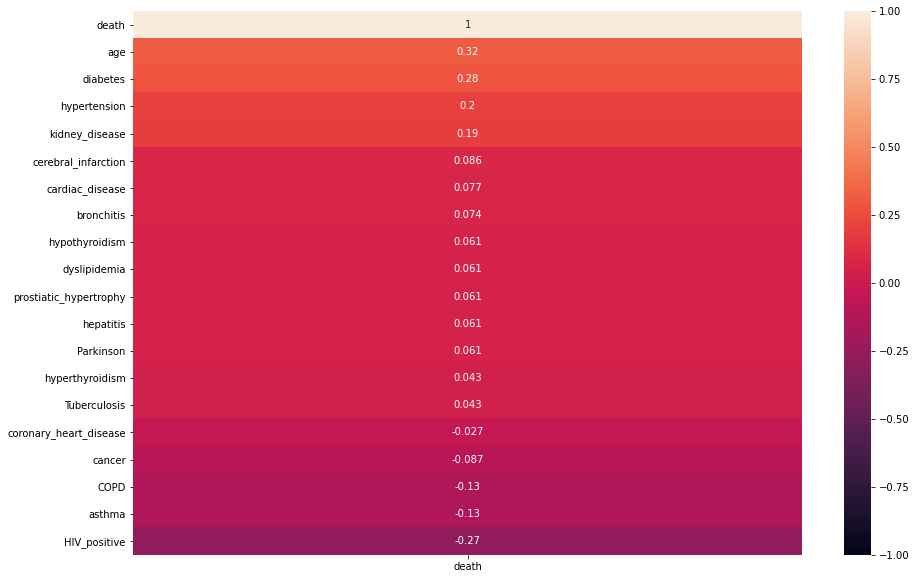

In [16]:
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(data_map.corr()[['death']].sort_values(by='death', ascending=False), vmin=-1, vmax=1, annot=True)

As we can see, age and diabetes play a huge role in the fatal casualties resulting from the Covid-19 virus infection.

It's time now to create our machine learning model. Since it's a classification problem, I'm going to deal with it applying a classic logistic regression algorithm with regularization. I'll first define functions that i'm going to use (Sigmoid, Cost, Gradient, prediction) and our independent and dependent variables; then the optimal parameters will be computed and the accurancy of the model will be tested.

In [17]:
# define Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# define Regularized Cost Function for Logistic Regression 
def lrcostFunctionReg(theta, X, y, lambda_t):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    reg_term = (lambda_t / (2 * m)) * (np.dot(theta[1:].T, theta[1:]))
    J = 1 / m * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h)) + reg_term
    return J

# define Gradient for Logistic Regression
def gradient(theta, X, y, lambda_t):
    m = len(y)
    grad = (1 / m) * np.dot(X.T, (sigmoid(np.dot(X, theta))) - y)
    grad[1:] = grad[1:] + (lambda_t / m) * theta[1:]
    return grad

# define prediction function
def predict(theta, X):
    h = sigmoid(np.dot(X, theta))
    p = (h >= 0.5)
    return p, h

In [18]:
#define the variables
X = data_map.iloc[:,:-1]
y = data_map.iloc[:, -1]

In [19]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                  Specs      Score
0                   age  50.903570
7          HIV_positive   8.869565
1              diabetes   5.306176
15       kidney_disease   4.058824
6                asthma   1.943787
14                 COPD   1.943787
9          hypertension   1.854753
17  cerebral_infarction   0.901961
4                cancer   0.891162
12           bronchitis   0.676471


In [20]:
X = bestfeatures.fit_transform(X,y)

In [21]:
(m,n) = X.shape
y = y.values
y_trans = y.reshape(-1,1)

In [22]:
# Compute optimal theta using optimization function fmin_tnc
# where func is our cost function and fprime is the gradient function
initial_theta = np.zeros((n, 1))
lmbda = 1
result = opt.fmin_tnc(func=lrcostFunctionReg, fprime=gradient, x0=initial_theta, args=(X, y_trans.flatten(), lmbda))
theta = result[0]
print('Optimal theta found: \n', theta)
theta_opt = theta.reshape(-1, 1)
print('Cost for optimal theta is: \n', lrcostFunctionReg(theta_opt, X, y, lmbda), ' with Lambda = ', lmbda)


Optimal theta found: 
 [ 0.01570136  1.13072277 -0.64181421 -0.57426026 -0.67482426  0.22449557
  0.46625275 -0.52415974  1.08124067  0.46696749]
Cost for optimal theta is: 
 [[66.95853034]]  with Lambda =  1


In [23]:
# Check for train accurancy
p, h = predict(theta, X)
print('Train Accurancy: ', np.mean((p == y.flatten()) * 100), ' with Lambda = ', lmbda)


Train Accurancy:  85.6  with Lambda =  1


With custom made algorithm, I've achieved an accurancy of 85.6 with a regularization feature of 1. 

Now I'm gonna use the Scikit library Logistic Regression algorithm to deploy a model and see how it would perform and differ from my custom made algorithms.

First I'm gonna import the needed Scikit libraries:

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Let's split the dataset in training and test data:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y.flatten(), test_size=0.2, random_state=1)


and then create the model:

In [26]:
model = LogisticRegression(solver='liblinear', C=0.01,random_state=0).fit(X_train, y_train)


Now we evaluate the model:

In [27]:
#score of the training set
model.score(X_train, y_train)

0.83

In [28]:
#score of the test set
model.score(X_test, y_test)

0.88

In [29]:
#defining predictions using the test set
y_pred = model.predict(X_test)

In [30]:
#final evaluation report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.88      1.00      0.93        21

    accuracy                           0.88        25
   macro avg       0.94      0.62      0.67        25
weighted avg       0.90      0.88      0.85        25



As we can see, with the Scikit algorithm we have achieved an accurancy of 0.88 which is pretty close to mine (0.86).

### Final considerations ###
This has been my first attemp to apply Machine Learning to a real-world case scenario and could represent a good starting point for further development and implementations, despite the lack of sources represented by the few complete cases represented in the nCoV2019 dataset.